# Python Boot Camp


Welcome! 😃👋

In this notebook, we will go through some basic image processing in Python, come across standard tasks required while setting up deep learning pipelines, and familiarize ourselves with popular packages such as `glob`, `tifffile`, `tqdm` and more.
We will learn about:
- Loading images (This is important as images are the primary input to most deep learning models)
- Normalizing images (This is important as it helps in faster convergence of models becuse it helps in reducing the scale of the input data and hence the scale of the gradients)
- Cropping images (This is important as it helps in creating smaller images from the original images which is useful for training models in a memory efficient way)
- Downsampling images (This is important as it helps in reducing the size of the images which is useful for training models in a memory efficient way)
- Flipping images (This is important as it helps in creating new images from the original data which is useful for training models in a memory efficient way)
- Batching images (As we train in a SGD manner, batching is important as it helps in training the model in a memory efficient way and smoothens the optimization process)
- Convolutions (This is important as it is the primary operation in Convolutional Neural Networks)
- Data Augmentation (This is important as it helps in artificially increasing the size of the training data which is useful for training models in a data efficient way)


We will be using sample images from the *MoNuSeg* dataset provided by [Kumar et al, 2018](https://ieeexplore.ieee.org/document/8880654). The data was publicly made available [here](https://monuseg.grand-challenge.org/) by the authors of the publication.

This dataset shows Hematoxylin and Eosin (H&E) Stained Images showing nuclei in different shapes.

## Chapter 0: Downloading data from an external url

Let us first download the images from an external url.
To do so, we need to import some commonly used dependencies.

In [7]:
from pathlib import Path # this library is used to handle file paths
import urllib.request, zipfile # urllib is used to download files from the internet, zipfile is used to extract zip files

Here, below is a helper function to download the data from an external url specified by argument `zip_url` and save it to a local directory specified by argument `project_name`. Let's execute the function (No output expected yet!).

In [8]:
def extract_data(zip_url, project_name):
    zip_path = Path(project_name + ".zip")
    if zip_path.exists():
        print("Zip file was downloaded and extracted before!")
    else:
        urllib.request.urlretrieve(zip_url, zip_path)
        print("Downloaded data as {}".format(zip_path))
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall("./")
    print("Unzipped data to {}".format(Path(project_name)))

Now we call the function `extract_data` specifying desirable values of the arguments.

In [9]:
extract_data(
    zip_url="https://owncloud.mpi-cbg.de/index.php/s/xwYonC9LucjLsY6/download",
    project_name="monuseg-2018",
)

Downloaded data as monuseg-2018.zip
Unzipped data to monuseg-2018


### Task 0.1
Click on the `Files` directory (left panel) and check if some images exist within the `monuseg-2018` directory.

### Task 0.2
Can you use a bash command to programmatically count the number of images and masks present in the `download/images` directory ?

*Hint*: Use `!ls -l <path> | wc - l` (you can run any bash command in a jupyter notebook by prefixing it with `!`) [Read more on this [here](https://linuxstans.com/wp-content/uploads/2023/06/bash-cheat-sheet.png)]

In [10]:
!ls -1 monuseg-2018/download/images | wc -l

14


## Chapter 1

### Images as arrays <a class="anchor" name="first"></a>

2D Images are often represented as numpy arrays of shape (`height`, `width`, `num_channels`).

![RGB image as a np array](https://github.com/dlmbl/boot/assets/34229641/ce1ad3f3-dc34-46d1-b301-198768fbc369)

<div style="text-align: right"> Credit: <a href="https://e2eml.school/convert_rgb_to_grayscale.html">Brandon Rohrer’s Blog</a></div>


Multiple utilities/packages exist to read images from files in Python.
For example, one can use `tifffile.imread` to read `*.tif` images. <br>Another good package is `skimage.io.imread`.


If you look in the directory (`monuseg-2018/download`), you can see directories called `images` and `masks`.

Let's load one image and visualize it using `matplotlib.pyplot.imshow`. <br>
`matplotlib.pyplot.imshow` is the standard way to show images in jupyter notebooks!

Image `img` has type <class 'numpy.ndarray'>


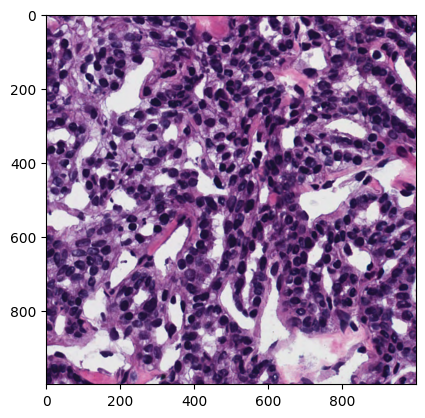

In [13]:
from tifffile import imread
import matplotlib.pyplot as plt

img = imread("monuseg-2018/download/images/TCGA-2Z-A9J9-01A-01-TS1.tif")
print(f"Image `img` has type {type(img)}")  # variable type
plt.imshow(img)

<div class="alert alert-info">

### Task 1.1
Can you visualize the corresponding `mask` for the image above? <br>
(*Hint*: Look for the same name within the `masks` directory.) <br>
What does the mask show?

Mask `mask` has type <class 'numpy.ndarray'>


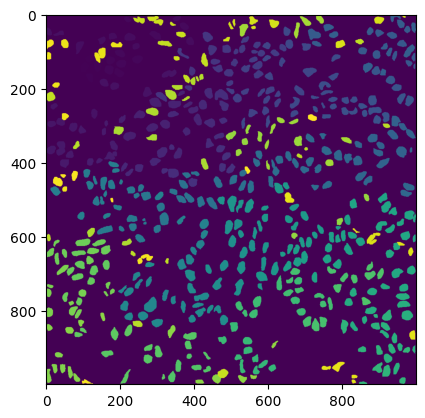

In [14]:
mask = imread("monuseg-2018/download/masks/TCGA-2Z-A9J9-01A-01-TS1.tif")
print(f"Mask `mask` has type {type(mask)}")  # variable type
plt.imshow(mask)

### Function description
There is a way in python to get the description of a function. This is useful when you are not sure what the function does or what arguments it takes.

<div class="alert alert-info">

### Task 1.2

Try to get the description of the `imread` function that we used above.

In [15]:
help(imread)

Help on function imread in module tifffile:

imread(files: 'str | os.PathLike[Any] | FileHandle | IO[bytes] | Sequence[str | os.PathLike[Any]] | None' = None, *, selection: 'Any | None' = None, aszarr: 'bool' = False, key: 'int | slice | Iterable[int] | None' = None, series: 'int | None' = None, level: 'int | None' = None, squeeze: 'bool | None' = None, maxworkers: 'int | None' = None, buffersize: 'int | None' = None, mode: "Literal['r', 'r+'] | None" = None, name: 'str | None' = None, offset: 'int | None' = None, size: 'int | None' = None, pattern: 'str | None' = None, axesorder: 'Sequence[int] | None' = None, categories: 'dict[str, dict[str, int]] | None' = None, imread: 'Callable[..., NDArray[Any]] | None' = None, imreadargs: 'dict[str, Any] | None' = None, sort: 'Callable[..., Any] | bool | None' = None, container: 'str | os.PathLike[Any] | None' = None, chunkshape: 'tuple[int, ...] | None' = None, chunkdtype: 'DTypeLike | None' = None, axestiled: 'dict[int, int] | Sequence[tuple[i

### Image channels
If the image is a `grayscale` image, then the number of channels is equal to $1$,
in which case the array can also be of shape (height, width). <br>
If the image is `RGB`, then the number of channels is $3$.
with each channel encoding the red, green and blue components.

<div class="alert alert-info">

### Task 1.3
Is <code>img</code> RGB or grayscale ? What about the mask?

*Hint*: <a href="https://assets.datacamp.com/blog_assets/Numpy_Python_Cheat_Sheet.pdf">np cheatsheet</a>

In [16]:
print(img.shape)
print(mask.shape)

(1000, 1000, 3)
(1000, 1000)


### Image data types


Images can be represented by a variety of data types. The following is a list of the most common datatypes:
- `bool`: binary, 0 or 1
- `uint8`: unsigned integers, 0 to 255 range
- `float`: -1 to 1 or 0 to 1

<div class="alert alert-info">

### Task 1.4
What is the data type of <code>img</code> and the <code>mask</code> ? What are the minimum and maximum intensity values?

*Hint*: <a href="https://assets.datacamp.com/blog_assets/Numpy_Python_Cheat_Sheet.pdf">np cheatsheet</a></div>

In [23]:
print("Mask max/min:", mask.max(), mask.min())
print("Img max/min:", img.max(), img.min())
print("Data types:", mask.dtype, img.dtype)

Mask max/min: 575 0
Img max/min: 255 0
Data types: uint16 uint8


### Reshaping Images

`PyTorch`, `TensorFlow` and `JAX` are popular deep learning frameworks.
<br> In `PyTorch` images are represented as (`num_channels`, `height`, `width`).

But the image which we are working with has the `channel` as the last axis.
Therefore, we need to reshape (by swapping) the image to the correct shape.

<div class="alert alert-info">

### Task 1.5
Reshape <code>img</code> such that its shape is <code>(num_channels, height, width)</code>

*Hint*: <a href="https://numpy.org/doc/stable/reference/generated/numpy.transpose.html">np transpose</a>

In [27]:
##########################
######## To Do ###########
##########################

import numpy as np

print(f"Before reshaping, image has shape {img.shape}")
img_reshaped = np.transpose(img, (2, 0, 1))
print(f"After reshaping, image has shape {img_reshaped.shape}")

Before reshaping, image has shape (1000, 1000, 3)
After reshaping, image has shape (3, 1000, 1000)


### Manipulating dimensions

Manipulating dimensions is a common operation in deep learning. <br>
Sometimes, the a neural network expects the input to be in a certain format, and we need to reshape the data accordingly. <br>
Lets add a batch dimension (batching will be introduced later) to the image. <br>
We can use `np.newaxis` to add a new axis to the image for this case as we are dealing with numpy arrays.
Later we will see how to do this in PyTorch using `torch.unsqueeze`.

In [29]:
img_with_batch = img_reshaped[np.newaxis, ...] #here we are adding a new axis at the 0th position, which is the batch dimension `...` means all the other dimensions
print(f"Image with batch has shape {img_with_batch.shape}")

Image with batch has shape (1, 3, 1000, 1000)


### Normalizing Images

Providing image inputs with intensities between [0, 1] often helps when training the model. <br>
This is because the gradients are more stable and the model converges faster, and the model is not biased towards any particular intensity values. <br>
One way of normalizing an image is to divide the intensity on each pixel by the maximum allowed intensity for the available data type.

<div class="alert alert-info">

### Task 1.6
Obtain an intensity normalized image using the idea above.

In [36]:
def normalize(img):
    norm_img = img / 255
    return norm_img

<div class="alert alert-info">

### Task 1.7
What is the data type of the normalized image. Has it changed from before? Why?

In [37]:
normalize(img).dtype

dtype('float64')

### Loading a set of images

Given a set of images in a folder, we need to be able to easily find the pathnames and load them in. <br>
`glob` is a standard package that provides a utility for finding all pathnames that match a given pattern.

Here, our images have the `.tif` extension.

In [38]:
import os
from glob import glob

img_dir = "monuseg-2018/download/images/"
img_filenames = sorted(glob(os.path.join(img_dir, "*.tif")))

print(f"Found:")
for img_filename in img_filenames:
    print(f"{img_filename}")

Found:
monuseg-2018/download/images/TCGA-2Z-A9J9-01A-01-TS1.tif
monuseg-2018/download/images/TCGA-44-2665-01B-06-BS6.tif
monuseg-2018/download/images/TCGA-69-7764-01A-01-TS1.tif
monuseg-2018/download/images/TCGA-A6-6782-01A-01-BS1.tif
monuseg-2018/download/images/TCGA-AC-A2FO-01A-01-TS1.tif
monuseg-2018/download/images/TCGA-AO-A0J2-01A-01-BSA.tif
monuseg-2018/download/images/TCGA-CU-A0YN-01A-02-BSB.tif
monuseg-2018/download/images/TCGA-EJ-A46H-01A-03-TSC.tif
monuseg-2018/download/images/TCGA-FG-A4MU-01B-01-TS1.tif
monuseg-2018/download/images/TCGA-GL-6846-01A-01-BS1.tif
monuseg-2018/download/images/TCGA-HC-7209-01A-01-TS1.tif
monuseg-2018/download/images/TCGA-HT-8564-01Z-00-DX1.tif
monuseg-2018/download/images/TCGA-IZ-8196-01A-01-BS1.tif
monuseg-2018/download/images/TCGA-ZF-A9R5-01A-01-TS1.tif


<div class="alert alert-info">

### Task 1.8
Load the set of masks, by correctly specifying the value of the variables `mask_dir` and `mask_filenames`

In [45]:
mask_dir = "monuseg-2018/download/images/"
mask_filenames = sorted(glob(os.path.join(mask_dir, "*.tif")))
for mask_filename in mask_filenames:
    print(f"{mask_filename}")

monuseg-2018/download/images/TCGA-2Z-A9J9-01A-01-TS1.tif
monuseg-2018/download/images/TCGA-44-2665-01B-06-BS6.tif
monuseg-2018/download/images/TCGA-69-7764-01A-01-TS1.tif
monuseg-2018/download/images/TCGA-A6-6782-01A-01-BS1.tif
monuseg-2018/download/images/TCGA-AC-A2FO-01A-01-TS1.tif
monuseg-2018/download/images/TCGA-AO-A0J2-01A-01-BSA.tif
monuseg-2018/download/images/TCGA-CU-A0YN-01A-02-BSB.tif
monuseg-2018/download/images/TCGA-EJ-A46H-01A-03-TSC.tif
monuseg-2018/download/images/TCGA-FG-A4MU-01B-01-TS1.tif
monuseg-2018/download/images/TCGA-GL-6846-01A-01-BS1.tif
monuseg-2018/download/images/TCGA-HC-7209-01A-01-TS1.tif
monuseg-2018/download/images/TCGA-HT-8564-01Z-00-DX1.tif
monuseg-2018/download/images/TCGA-IZ-8196-01A-01-BS1.tif
monuseg-2018/download/images/TCGA-ZF-A9R5-01A-01-TS1.tif


Let's visualize some of the images and the corresponding mask, side by side. First let's provide a helper `visualize` function which takes two images as argument.


In [49]:
import matplotlib.pyplot as plt

def visualize(im1, im2):
    plt.figure(figsize=(10, 10))
    plt.subplot(121)
    plt.imshow(im1)
    plt.subplot(122)
    plt.imshow(im2)
    plt.tight_layout()

Executing the cell below, would visualize a new random image and the corresponding segmentation mask, each time. This is because the variable `idx` gets a new value between $0$ and $14$ (there are $15$ images).

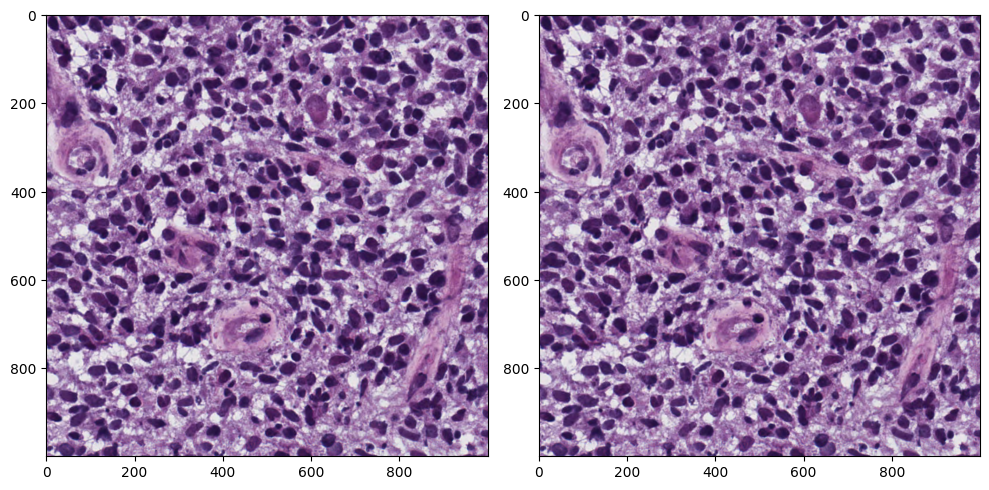

In [50]:
idx = 8 #change this value to visualize a different image and mask to explore the dataset
visualize(imread(img_filenames[idx]), imread(mask_filenames[idx]))

Note that all the labels in the right image have different colors. This is because the mask is a instance mask where each color represents a different class.
The colors indicate an unique id for each object in the image.

<div class="alert alert-success">

## Checkpoint 1

Great Job! 🎊 Please post in the chat when you reach this checkpoint.

In the first chapter, we learned about:

<li> image data types</li>
<li> reshaping images </li>
<li> normalizing images </li>
<li> Using <code>glob</code> to load a set of images

These are important concepts to understand as they form the basis of most image processing pipelines because they are the basic data handling operations.

<hr>
</div>

**Bonus Task for Chapter 1**: Can you think of alternate approaches to intensity normalization? Any benefits of following one over the other?

Another approach could be percentile normalization. This maps the min intensity to 0 and max intensity to 0. This is useful if there are
outliers in the data. The benefit of this approach is that it is robust to outliers.

## Chapter 2
### Cropping

While training models, we usually feed in smaller crops extracted from the original images.
To do so, we can rely on the powerful numpy [indexing](https://numpy.org/doc/stable/user/basics.indexing.html).

For example, let's extract the top left (second) quadrant from one of our images.

In the cell below, the original image is visualized on the left and the cropped image is seen on the right.

In [ ]:
idx = np.random.randint(len(img_filenames))
img = imread(img_filenames[idx])
cropped_img = img[0:500, 0:500, :]
visualize(img, cropped_img)

<div class="alert alert-info">

### Task 2.1
Visualize the bottom left (third) quadrant of a random image

In [ ]:
##########################
######## To Do ###########
##########################

idx = np.random.randint(len(img_filenames))
img = imread(img_filenames[idx])
cropped_img = ...  # TODO : fill correct value!!
visualize(img, cropped_img)

### Downsampling

For large images, sometimes we require that they are downsampled to fit in memory. <br>

**Note:** Downsampling is a lossy operation, as we are removing information from the image. If your images contain important information in the removed pixels, this can be detrimental to the model's performance. <br>
This is usually not a problem for images with a high resolution, as the removed information is often redundant. <br>
However, if subtle structes in the content of your image is important, it is better to crop the image rather than downsample it. <br>

Say if one wants to have every fourth pixel from the original image, one specifies `factor` = $4$, and one can run the following cell:

In [ ]:
# downsampling
idx = np.random.randint(len(img_filenames))
img = imread(img_filenames[idx])

factor = 4
downsampled_img = img[::factor, ::factor] # here we are selecting every 'factor' pixel in the height and width dimension
print(f"Original image shape: {img.shape}")
print(f"Downsampled image shape: {downsampled_img.shape}")

# Let's visualize the original image and the downsampled image side by side
visualize(img, downsampled_img)

<div class="alert alert-info">

### Task 2.2
Can you see that the image on the right lacks some detail on account of being downsampled? <br>
This might not be readily evident now, but if you look closely, you can see that the image on the right is a bit blurry. <br>
This is because we are skipping pixels while downsampling.

To make the effect more evident, try other extreme values of the downsampling `factor`.

In [ ]:
##########################
######## To Do ###########
##########################

factor = ...
downsampled_img = img[::factor, ::factor]
visualize(img, downsampled_img)

### Flipping

Sometimes, one wishes to create new images from original data by performing transformations.

One way to create a new image is by flipping an image about a given axis, which creates a mirror image!

Run the following cell to visualize a vertically flipped image.

In [ ]:
idx = np.random.randint(len(img_filenames))
img = imread(img_filenames[idx])
# Here the image dimensions are (height, width, num_channels), ::-1 means reverse the order of the elements in the array on the height axis
vflipped_img = img[::-1, :, :]
visualize(img, vflipped_img)

<div class="alert alert-info">

### Task 2.3
Create a horizontally flipped image and visualize!

In [ ]:
##########################
######## To Do ###########
##########################

idx = np.random.randint(len(img_filenames))
img = imread(img_filenames[idx])
hflipped_img = ...  ## TODO: fill correct value
visualize(img, hflipped_img)

<div class="alert alert-info">

### Bonus Task for Chapter 2
Can you think of any other reason why we need to crop images, aside from saving memory?

In [ ]:
##########################
######## To Do ###########
##########################

<div class="alert alert-success">

<hr>
Fantastic Work! 🙏 Please post on the course chat when you reach this checkpoint.

## Checkpoint 2

In the second chapter, we learnt about:

<li> cropping images </li>
<li> downsampling images </li>
<li> flipping images </li>

These operations are important as they help in creating new images from the original data.
These are also ways of basic data augmentation which is useful for training models.

<hr>
</div>

**Bonus Task for Chapter 2**

Can you think of reasons why we need to crop images?
Can't we feed in all the images at the original size to the model?

1. To increase the amount of data i.e, have more training data and corresponding masks
2. Also because often the training images come with different sizes and this creates an issue while `batching` the images

## Chapter 3
### Batching

In ML/DL, we often have to deal with very large datasets. It soon becomes inefficient to process all the data at once, so it's useful to split the data into "mini-batches" that we can process individually.

So for purely reasons of computational cost, this is often useful.

We will also see another reason for which batching can be useful - for instance when running gradient descent on non-convex landscapes.
Here, computing the gradient on a subset of the data gives us an approximate/noisy gradient making it less likely for us to end up being stuck in local minima. This is what is referred to as "stochastic gradient descent".

Let us make our first batch of images, containing $B$ number of images.
The shape of the batch will thus get an additional "batch dimension" at the first dimension, i.e. (batch_size, num_channels, height, width).

<div class="alert alert-info">

### Task 3.1

Make a batch of size $B=4$ by sampling 4 images randomly from the available images (this will be a 4D np array).
<br> Here, you would also have to ensure that the second axis corresponds to the channel (use `np.transpose`)

**Hint**: Use `np.random.choice` to sample 4 random indices from the list of image filenames.
`np.random.randint` (which we have used above) to select batches could give duplicate images in a batch. In this case, your batch should contain 4 unique images.

In [ ]:
##########################
######## To Do ###########
##########################

# `batch` should be a np array with shape (4, 3, 1000, 1000).

batch = ...  # TODO
print(f"Batch of images has shape {batch.shape}")

### Convolutions

Convolutions are the elementary operations used in Convolutional Neural Networks (CNNs). <br> The images (and later, the feature maps) are convolved with multiple filters whose weights are learned. <br>

![](https://upload.wikimedia.org/wikipedia/commons/1/19/2D_Convolution_Animation.gif)


Please read this section https://en.wikipedia.org/wiki/Kernel_(image_processing)#Convolution on convolutions to learn how to implement a your own convolution function!

Here we will optionally demonstrate TQDM which is a package that provides a progress bar for loops.
This is useful when you have a loop that takes a long time to run and you want to know how far along the loop is.
Read more about TQDM [here](https://tqdm.github.io/)

<div class="alert alert-info">

### Task 3.2
Implement a function that performs a convolution of an image with a filter.
<br> Assume that your image is square and that your filter is square and has an odd width. You can set arbitrary values in your filter for now.
<br> Note that your output image will be smaller.

**A few things to note:** <br>
-- Filter: A filter is a matrix that is convolved with the image. The filter is also known as a kernel. It computes the correlation between the itself and the image. It is kind of finding the similarity between the filter and the image.
The filter is applied to the image by sliding the filter over the image and computing the dot product between the filter and the image at each location. The output of the convolution is called the feature map (a concept that will come up in future exercises).

-- The filter is usually a square matrix with odd dimensions. This is because the filter is applied to the image by sliding it over the image. If the filter has even dimensions, it will not have a center pixel. This will make it difficult to align the filter with the image.
If the filter is not square, we loose the symmetrical applicability of the filter. The filter then will have to be applied in different directions (height, width) separately. This will make the implementation more complex and migt lead to distortions in the output features.

In [ ]:
##########################
######## To Do ###########
##########################

from tqdm import tqdm # tqdm is used to show progress bars in loops

def conv2d(img, kernel):
    assert kernel.shape[0] == kernel.shape[1]
    assert kernel.shape[0] % 2 != 0

    h, w = img.shape[0], img.shape[1]  # Starting size of image
    d_k = kernel.shape[0]  # Size of kernel

    h_new = h - d_k + 1  # Calculate the new height of the array
    w_new = w - d_k + 1  # Calculate the new width of the array
    output = np.zeros((h_new, w_new))

    # TODO: add your code for filling output with the convolved image
    for i in tqdm(range(output.shape[0]), desc="Processing rows", position=0, leave=True):
        for j in tqdm(range(output.shape[1]),desc="Processing columns", position=0, leave=False):
            ...

    return output

In [ ]:
# Run this cell to check your function

identity = np.array([[0, 0, 0],
                     [0, 1, 0],
                     [0, 0, 0]])
# Let's take a 256x256 center crop of the image for better visualization of the effect of the convolution
new_im = conv2d(img[128:384, 128:384, 0], identity)
# Lets print the original image and the convolved image
print(img[128:384, 128:384, 0].shape)
print(new_im.shape)

#Lets visualize the original image and the convolved image and the filter
plt.figure(figsize=(10, 10))
plt.subplot(131)
plt.imshow(img[128:384, 128:384, 0])
plt.title("Original Image")
plt.subplot(132)
plt.imshow(identity)
plt.title("Kernel")
plt.subplot(133)
plt.imshow(new_im)
plt.title("Convolved Image")
plt.tight_layout()

**Bonus: Try differnt (arbitary?) filters and see how the output changes! You can find some here: https://en.wikipedia.org/wiki/Kernel_(image_processing)**

<div class="alert alert-info">

### Task 3.3

We noticed that the output image is smaller than the input image! <br>

Can you come up with an analytical relationship regarding how much smaller the output image is *vis-à-vis* the input image? <br>
Can you think of any strategy which ensures that the output image is the same size as the input image?

In [ ]:
##########################
######## To Do ###########
##########################

### Filters

Let us try to understand what could the values of the filter be. <br>


<div class="alert alert-info">

The following is known as the [Sobel filter](https://en.wikipedia.org/wiki/Sobel_operator):

$$
\begin{bmatrix}
    1 & 2 & 1 \\
    0 & 0 & 0 \\
    -1 & -2 & -1
\end{bmatrix}
$$

### Task 3.4
Apply the Sobel filter and describe what it does

In [ ]:
##########################
######## To Do ###########
##########################

flter = ...  # TODO
output_img = conv2d(img[128:384, 128:384, 0], flter)
visualize(img[128:384, 128:384, 0], output_img)

<div class="alert alert-info">

### Task 3.5

What feature in this image do you think this filter is detecting?

In [ ]:
##########################
######## To Do ###########
##########################

<div class="alert alert-success">

<hr>
Wow! 🤟 Post on the course chat when you reach this checkpoint!

## Checkpoint 3

In the third chapter, we learnt about:

<li> Batching (here we understood the importance of batching in training models) </li>
<li> Convolutions (The primary operation in Convolutional Neural Networks) </li>
<li> Filters (The weights that are learned in Convolutional Neural Networks) </li>

<hr>

## Chapter 4: Data augmentation

Having collected your hard earned data you want to make the most of it. In ML/DL, we're often limited by the size of our the training set.
How could we artificially increase our data to provide more input to our model and help it generalize better?

One trick is to make simple transformations to our data such as rotating or flipping it - this process is generally called "data augmentation" (DA) and is widely used in ML.

Here we will implement some basic data augmentation techniques using numpy.

**Note:** This is a good opportunity to learn how this augmentations work under the hood.
However in practice, we would use libraries like `torchvision` or `monai` which are optimized for speed and have a wide range of augmentations available.

### Applying one augmentation at a time
Lets apply one augmentation to the image at a time.
**Note:** With advanced libraries like `torchvision` or `monai`, you can apply multiple augmentations at once. [Read more about [Torchvision](https://pytorch.org/vision/stable/index.html) and [Monai](https://docs.monai.io/en/latest/transforms.html)]

In [ ]:
# Flip horizontally
img_flip_horizontal = img[:, ::-1]
# Flip vertically
img_flip_vertical = img[::-1, :]
# Rotate by 45 degrees
img_rotate = np.rot90(img, k=1)

#Let's visualize the original image and the augmented image
plt.figure(figsize=(10, 10))
plt.subplot(141)
plt.imshow(img)
plt.title("Original Image")
plt.subplot(142)
plt.imshow(img_flip_horizontal)
plt.title("Horizontal Flip")
plt.subplot(143)
plt.imshow(img_flip_vertical)
plt.title("Vertical Flip")
plt.subplot(144)
plt.imshow(img_rotate)
plt.title("Rotate by 45 degrees")
plt.tight_layout()

<div class="alert alert-info">

### Task 4.1
Familiarize yourself with the different augmentations available through `torchvision`.

Refer to the [examples](https://pytorch.org/vision/0.13/transforms.html) and identify and apply augmentations that you think are interesting.

In [ ]:
##########################
######## To Do ###########
##########################

<div class="alert alert-info">

### Task 4.2
Q1. While augmenting images and segmentation masks, should they be augmented similarly or differently? Discuss. <br>
Q2. What are the disadvantages of augmenting images? When can it be harmful?

In [ ]:
##########################
######## To Do ###########
##########################

<div class="alert alert-success">

<hr>
Hurrah! 😃

## Checkpoint 4

In the fourth chapter, we learnt about data augmentation which is an important concept in training models. Data augmentation helps in artificially increasing the size of the training data which is useful for training models in a data efficient way.
We implemented some basic data augmentation techniques using numpy.

<hr>

## Chapter 5: (Optional) Advanced Plotting and Visualization

Python's matplotlib is a powerful library for creating visualizations.
It is also highly customizable and can be used to create complex plots.
In deep learning, visualizing the data is important as it helps in understanding the data and the model better.
Therefore, it is important to know how to create different types of plots using matplotlib with specific (useful) functions.

### Colormap
You can choose a specific colormap to visualize your images.
Read more about colormaps [here](https://matplotlib.org/stable/tutorials/colors/colormaps.html)

In [ ]:
plt.imshow(img[..., 0], cmap="magma")  #Note that we are only showing the first channel of the image
plt.axis("off")
plt.show()


### Colorbar
Sometimes, you may want to add a colorbar to your image to show the intensity values.

**Note**: The <code>vmin</code> and <code>vmax</code> arguments are used to set the range of the colorbar.
In this case, the intensity values range from 0 to 255. But you can set the range to any values you want (based on the intensity values in the image). <br>
**Note**: for plotting colorbar for instance mask (in the future), you can use <code>viridis</code> colormap for the mask for better visualization.

In [ ]:
plt.figure(figsize=(6, 6))
plt.imshow(img[..., 0], cmap="magma", vmin=0, vmax=255)
plt.colorbar()
plt.axis("off")
plt.show()


### Plotting Histograms
- Let's see the histogram of the intensity values
- <code>img</code> is an 8-bit image, so the intensity values range from 0 to 255

In [ ]:
plt.figure(figsize=(6, 6))
# bins indicate how may unique buclets you might want to put your values in and range is the min and max values in the image
# Try different values for bins and range to see how the histogram changes
plt.hist(img[..., 0].ravel(), bins=255, range=(0.0, img[..., 0].max()))
plt.xlabel("Intensity Value")
plt.ylabel("Count")
plt.show()

Often we might need to plot multiple images side by side.
Let's plot the crop of the original image from different locations side by side.

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax[0, 0].imshow(img[0:512, 0:512, :], cmap="magma")
ax[0, 1].imshow(img[512:, 512:, :], cmap="magma")
ax[1, 0].imshow(img[512:, 0:512, :], cmap="magma")
ax[1, 1].imshow(img[0:512, 512:, :], cmap="magma")

<div class="alert alert-info">

### Task 5.1
With all that knowledge, let's plot the 4 crop of the image in a first row and their histograms in a second row.

In [ ]:
##########################
######## To Do ###########
##########################

<div class="alert alert-success">

<hr>
Hurrah! 😃

## Checkpoint 5

Chapter 5 is a bonus chapter where we learnt about:

<li> Using colormaps to visualize images </li>
<li> Adding colorbars to images </li>
<li> Plotting histograms </li>
<li> Plotting multiple images side by side </li>
<hr>